In [1]:
import pandas as pd
import numpy as np  


import seaborn as sns
import matplotlib.pyplot as plt


from sklearn.metrics import mean_squared_error
from sklearn.svm import SVR
import sklearn


from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
import optuna

import xgboost as xgb


In [2]:
sol_phys_train = pd.read_csv('../data/interim/solar_phys_train.csv')
sol_phys_train = sol_phys_train.drop('Unnamed: 0', axis=1)
sol_phys_train.head()

,Radiation,Temperature,Pressure,Humidity,WindDirection(Degrees),Speed
0,634.99,289.26,4060.99,41,0.0416,3.02
1,1.27,275.93,4034.32,70,0.5762,2.51
2,1.21,281.48,4064.99,33,0.4672,2.51
3,1.67,285.37,4060.99,101,0.4239,1.51
4,839.78,289.82,4062.32,36,0.8110,3.52


In [3]:
sol_phys_train.describe()

,Radiation,Temperature,Pressure,Humidity,WindDirection(Degrees),Speed
count,24514.000000,24514.000000,24514.000000,24514.000000,24514.000000,24514.000000
mean,208.062687,283.763923,4056.016801,75.002284,0.397581,2.793646
std,316.133238,3.452542,7.299362,25.999994,0.230388,1.556280
min,1.130000,274.260000,4024.990000,11.000000,0.000300,0.000000
25%,1.230000,280.930000,4052.990000,55.000000,0.227400,1.510000
50%,2.720000,283.150000,4056.990000,85.000000,0.409950,2.510000
75%,359.927500,285.930000,4060.990000,97.000000,0.497800,3.520000
max,1601.260000,294.820000,4074.320000,103.000000,0.999900,17.600000


In [4]:

X = sol_phys_train[[c for c in sol_phys_train if c != 'Radiation']].values
y = sol_phys_train[['Radiation']].values


In [5]:
X_train, X_val, y_train, y_val = sklearn.model_selection.train_test_split(X, y,random_state=0, test_size=0.30)

def objective(trial):
    # Invoke suggest methods of a Trial object to generate hyperparameters.
    regressor_name = trial.suggest_categorical('classifier', ['SVR', 'RandomForest'])
    
    
    if regressor_name == 'SVR':
        svr_c = trial.suggest_loguniform('svr_c', 1e-10, 1e10)
        epsilon = trial.suggest_loguniform('epsilon', 1e-1, 1e1)
        regressor_obj = sklearn.svm.SVR(C=svr_c, epsilon=epsilon, gamma='auto')
        
        
    else:
        rf_max_depth = trial.suggest_int('rf_max_depth', 2, 32)
        rf_max_estimators = trial.suggest_int('n_estimators', 1, 300)
        regressor_obj = RandomForestRegressor(max_depth=rf_max_depth, criterion='mse', n_estimators = rf_max_estimators)

    
    regressor_obj.fit(X_train, y_train)
    y_pred = regressor_obj.predict(X_val)

    error = sklearn.metrics.mean_squared_error(y_val, y_pred)

    return error  # An objective value linked with the Trial object.

In [6]:
def objective_rm(trial):
# Invoke suggest methods of a Trial object to generate hyperparameters.

    rf_max_depth = trial.suggest_int('rf_max_depth', 2, 64)
    rf_max_estimators = trial.suggest_int('n_estimators', 1, 3000)
        
    
    model = RandomForestRegressor(max_depth=rf_max_depth, criterion='mse', n_estimators = rf_max_estimators)
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_val)
    error = sklearn.metrics.mean_squared_error(y_val, y_pred)
    
    
    return error # An objective value linked with the Trial object.

In [7]:
#study_rm = optuna.create_study()
#study_rm.optimize(objective_rm, n_trials=100)
#study_rm.best_params

In [8]:
#26826.7851407973 with parameters: {'rf_max_depth': 16, 'n_estimators': 268}

In [9]:
sc_X = MinMaxScaler()
sc_y = MinMaxScaler()
X_sc = sc_X.fit_transform(X)
y_sc = sc_y.fit_transform(y)

In [10]:
X_sc_train, X_sc_val, y_sc_train, y_sc_val = sklearn.model_selection.train_test_split(X_sc, y_sc, random_state=0, test_size=0.30)

In [52]:
def objective_xgb(trial):
# Invoke suggest methods of a Trial object to generate hyperparameters.

    
    dtrain = xgb.DMatrix(X_train, label = y_train)
    dvalid = xgb.DMatrix(X_val, label = y_val)

    param = {
        "silent": 1,
        "objective": 'reg:linear',
        "booster": trial.suggest_categorical("booster", ["gbtree", "gblinear", "dart"]),
        "lambda": trial.suggest_loguniform("lambda", 1e-8, 1.0),
        "alpha": trial.suggest_loguniform("alpha", 1e-8, 1.0),
        'eval_metric': 'rmse'
    }

    if param["booster"] == "gbtree" or param["booster"] == "gblinear":
        param["subsample"] = trial.suggest_loguniform("subsample", 1e-8, 1.0)
        param["n_trees"] = trial.suggest_int("n_trees", 1, 1000)        
        param["max_depth"] = trial.suggest_int("max_depth", 1, 64)
        param["eta"] = trial.suggest_loguniform("eta", 1e-8, 1.0)
        param["gamma"] = trial.suggest_loguniform("gamma", 1e-8, 1.0)
        param["grow_policy"] = trial.suggest_categorical("grow_policy", ["depthwise", "lossguide"])
    
    if param["booster"] == "dart":
        param["max_depth"] = trial.suggest_int("max_depth", 1, 64)
        param["subsample"] = trial.suggest_loguniform("subsample", 1e-8, 1.0)
        param["n_trees"] = trial.suggest_int("n_trees", 1, 1000) 
        param["sample_type"] = trial.suggest_categorical("sample_type", ["uniform", "weighted"])
        param["normalize_type"] = trial.suggest_categorical("normalize_type", ["tree", "forest"])
        param["rate_drop"] = trial.suggest_loguniform("rate_drop", 1e-8, 1.0)
        param["skip_drop"] = trial.suggest_loguniform("skip_drop", 1e-8, 1.0)
    
    bst = xgb.train(param, dtrain)
    y_pred = bst.predict(dvalid)
 
    error = sklearn.metrics.mean_squared_error(y_val, y_pred)
    
    
    return error # An objective value linked with the Trial object.

In [53]:
study_xgb = optuna.create_study()
study_xgb.optimize(objective_xgb, n_trials=300)
study_xgb.best_params

[I 2020-05-05 10:36:44,320] Finished trial#0 with value: 100114.44512409453 with parameters: {'booster': 'gblinear', 'lambda': 0.0010966435901275736, 'alpha': 6.815674053418314e-06, 'subsample': 0.4957414673613707, 'n_trees': 702, 'max_depth': 32, 'eta': 0.1400821476245132, 'gamma': 2.970961167637978e-06, 'grow_policy': 'depthwise'}. Best is trial#0 with value: 100114.44512409453.
[I 2020-05-05 10:36:44,463] Finished trial#1 with value: 100206.67634318947 with parameters: {'booster': 'gblinear', 'lambda': 0.013206692035843761, 'alpha': 0.03212144761370978, 'subsample': 7.383415621449694e-08, 'n_trees': 737, 'max_depth': 31, 'eta': 0.1318965279776783, 'gamma': 0.0030992203749217514, 'grow_policy': 'lossguide'}. Best is trial#0 with value: 100114.44512409453.
[I 2020-05-05 10:36:44,604] Finished trial#2 with value: 146025.6472874235 with parameters: {'booster': 'gbtree', 'lambda': 3.457836383519157e-06, 'alpha': 9.676864442421126e-06, 'subsample': 3.0607206326078483e-06, 'n_trees': 971, 

[I 2020-05-05 10:36:55,933] Finished trial#39 with value: 91854.32773842155 with parameters: {'booster': 'gblinear', 'lambda': 2.7319797236099612e-08, 'alpha': 0.5786779205399849, 'subsample': 0.04864343410828376, 'n_trees': 416, 'max_depth': 35, 'eta': 0.7284868322866572, 'gamma': 2.9549022427136264e-05, 'grow_policy': 'depthwise'}. Best is trial#35 with value: 29139.990290458383.
[I 2020-05-05 10:36:56,520] Finished trial#40 with value: 35715.833187366035 with parameters: {'booster': 'gbtree', 'lambda': 3.3883466506950864e-07, 'alpha': 0.2548751076634811, 'subsample': 0.9553218649491887, 'n_trees': 324, 'max_depth': 9, 'eta': 0.7647925821076715, 'gamma': 0.0001421340489639344, 'grow_policy': 'depthwise'}. Best is trial#35 with value: 29139.990290458383.
[I 2020-05-05 10:36:56,724] Finished trial#41 with value: 31937.81235561593 with parameters: {'booster': 'dart', 'lambda': 1.3768060488996922e-06, 'alpha': 5.2222600578613794e-05, 'max_depth': 4, 'subsample': 0.39569747323450905, 'n_t

[I 2020-05-05 10:37:07,585] Finished trial#77 with value: 102357.96166104822 with parameters: {'booster': 'gbtree', 'lambda': 3.2518899641014714e-08, 'alpha': 0.06387979108335169, 'subsample': 0.8899275921763198, 'n_trees': 98, 'max_depth': 18, 'eta': 0.02270008221886769, 'gamma': 5.9384690833703285e-06, 'grow_policy': 'depthwise'}. Best is trial#35 with value: 29139.990290458383.
[I 2020-05-05 10:37:08,075] Finished trial#78 with value: 42237.08052593866 with parameters: {'booster': 'dart', 'lambda': 0.00012046383192447911, 'alpha': 0.10420966991304473, 'max_depth': 11, 'subsample': 0.13905119755476397, 'n_trees': 570, 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 0.012171534935513801, 'skip_drop': 0.7252101649039294}. Best is trial#35 with value: 29139.990290458383.
[I 2020-05-05 10:37:08,274] Finished trial#79 with value: 90685.38648108853 with parameters: {'booster': 'gblinear', 'lambda': 0.0005658926593846798, 'alpha': 0.026610458449986562, 'subsample': 0.06913

[I 2020-05-05 10:37:21,071] Finished trial#116 with value: 30456.48487603448 with parameters: {'booster': 'dart', 'lambda': 1.0035331524733755e-07, 'alpha': 0.1334217732568865, 'max_depth': 6, 'subsample': 0.7206018814325338, 'n_trees': 663, 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 0.0017450276482578711, 'skip_drop': 0.005059939460728832}. Best is trial#85 with value: 28840.67622624989.
[I 2020-05-05 10:37:21,517] Finished trial#117 with value: 37931.58409323176 with parameters: {'booster': 'dart', 'lambda': 4.000634112365042e-08, 'alpha': 0.054832209550996325, 'max_depth': 13, 'subsample': 0.317298688444958, 'n_trees': 850, 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 0.0075031477916425995, 'skip_drop': 1.4634661773742197e-08}. Best is trial#85 with value: 28840.67622624989.
[I 2020-05-05 10:37:21,836] Finished trial#118 with value: 29187.09187474412 with parameters: {'booster': 'dart', 'lambda': 1.533660785873664e-07, 'alpha': 0.375752015

[I 2020-05-05 10:37:36,030] Finished trial#154 with value: 30187.830126053268 with parameters: {'booster': 'dart', 'lambda': 5.970055437051682e-08, 'alpha': 0.3064656838216804, 'max_depth': 8, 'subsample': 0.5786488670935519, 'n_trees': 852, 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 0.02638872292448629, 'skip_drop': 0.007937359116895736}. Best is trial#85 with value: 28840.67622624989.
[I 2020-05-05 10:37:36,358] Finished trial#155 with value: 31025.453168329528 with parameters: {'booster': 'dart', 'lambda': 2.5577211964692953e-08, 'alpha': 0.20458077409435607, 'max_depth': 7, 'subsample': 0.4392133080945046, 'n_trees': 913, 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 0.010758655805336234, 'skip_drop': 0.01642098592295908}. Best is trial#85 with value: 28840.67622624989.
[I 2020-05-05 10:37:37,085] Finished trial#156 with value: 32734.872917863962 with parameters: {'booster': 'dart', 'lambda': 4.969218535712883e-08, 'alpha': 0.300613948739091

[I 2020-05-05 10:37:46,837] Finished trial#192 with value: 29125.049905130756 with parameters: {'booster': 'dart', 'lambda': 3.7426835301788635e-07, 'alpha': 0.26332682587071204, 'max_depth': 8, 'subsample': 0.9999180186344341, 'n_trees': 666, 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 0.00011783989792507878, 'skip_drop': 0.01644987694682544}. Best is trial#172 with value: 28699.28910928496.
[I 2020-05-05 10:37:47,308] Finished trial#193 with value: 31382.91740596715 with parameters: {'booster': 'dart', 'lambda': 4.1184847986830826e-07, 'alpha': 0.2894668723203873, 'max_depth': 8, 'subsample': 0.3910638542122163, 'n_trees': 668, 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 0.00013345634130232893, 'skip_drop': 0.015708811319210876}. Best is trial#172 with value: 28699.28910928496.
[I 2020-05-05 10:37:47,633] Finished trial#194 with value: 29215.03234289669 with parameters: {'booster': 'dart', 'lambda': 7.945681340735226e-07, 'alpha': 0.3625998

[I 2020-05-05 10:38:01,224] Finished trial#230 with value: 146025.6472874235 with parameters: {'booster': 'dart', 'lambda': 8.17368904431784e-08, 'alpha': 0.3933508259625901, 'max_depth': 8, 'subsample': 3.4074678053557776e-08, 'n_trees': 590, 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 0.00011081671580942672, 'skip_drop': 0.010096988948361026}. Best is trial#172 with value: 28699.28910928496.
[I 2020-05-05 10:38:01,474] Finished trial#231 with value: 29987.208883931107 with parameters: {'booster': 'dart', 'lambda': 1.5414343547070364e-07, 'alpha': 0.998621897553272, 'max_depth': 6, 'subsample': 0.8988813969345714, 'n_trees': 530, 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 6.370268537531154e-05, 'skip_drop': 0.012747060766913251}. Best is trial#172 with value: 28699.28910928496.
[I 2020-05-05 10:38:01,741] Finished trial#232 with value: 29119.952035189646 with parameters: {'booster': 'dart', 'lambda': 2.517641897414043e-07, 'alpha': 0.674609

[I 2020-05-05 10:38:13,759] Finished trial#268 with value: 30256.83727170486 with parameters: {'booster': 'dart', 'lambda': 9.328185776565561e-07, 'alpha': 0.31251517221887687, 'max_depth': 10, 'subsample': 0.9995540581379938, 'n_trees': 474, 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 0.001013445628309101, 'skip_drop': 0.018243535324122772}. Best is trial#172 with value: 28699.28910928496.
[I 2020-05-05 10:38:13,978] Finished trial#269 with value: 146025.6472874235 with parameters: {'booster': 'dart', 'lambda': 1.6118113404457308e-06, 'alpha': 0.4984423637820137, 'max_depth': 4, 'subsample': 5.820201932956702e-07, 'n_trees': 501, 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 0.0006780206511699335, 'skip_drop': 0.008734610942333541}. Best is trial#172 with value: 28699.28910928496.
[I 2020-05-05 10:38:14,257] Finished trial#270 with value: 29557.577013472102 with parameters: {'booster': 'dart', 'lambda': 2.8619650262347514e-07, 'alpha': 0.3

{'booster': 'dart',
 'lambda': 2.714102233686138e-07,
 'alpha': 0.2580966261871846,
 'max_depth': 8,
 'subsample': 0.9889076425765149,
 'n_trees': 739,
 'sample_type': 'weighted',
 'normalize_type': 'tree',
 'rate_drop': 0.0002137597037856947,
 'skip_drop': 0.007909933442167151}

In [54]:
xgb_params = study_xgb.best_params
xgb_params

{'booster': 'dart',
 'lambda': 2.714102233686138e-07,
 'alpha': 0.2580966261871846,
 'max_depth': 8,
 'subsample': 0.9889076425765149,
 'n_trees': 739,
 'sample_type': 'weighted',
 'normalize_type': 'tree',
 'rate_drop': 0.0002137597037856947,
 'skip_drop': 0.007909933442167151}

In [55]:
dtrain = xgb.DMatrix(X_sc_train, y_sc_train)
dtest = xgb.DMatrix(X_sc_val)

[0]	train-rmse:0.303726	test-rmse:0.305155


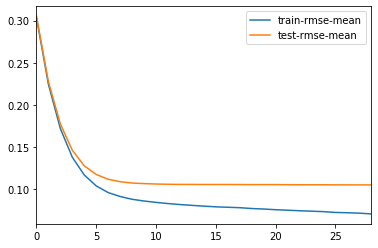

In [56]:
cv_output = xgb.cv(xgb_params, dtrain, num_boost_round=1000, early_stopping_rounds=50,
    verbose_eval=200, show_stdv=False)
cv_output[['train-rmse-mean', 'test-rmse-mean']].plot()
plt.show()

In [ ]:
num_boost_rounds = len(cv_output)
print(num_boost_rounds)

model = xgb.train(dict(xgb_params, silent=0), dtrain, num_boost_round= num_boost_rounds)

In [39]:
sol_phys_test = pd.read_csv('../data/interim/solar_phys_test.csv')
sol_phys_test = sol_phys_test.drop('Unnamed: 0', axis=1)
sol_phys_test.head()

,id,Temperature,Pressure,Humidity,WindDirection(Degrees),Speed
0,0,288.15,4062.32,44,0.8685,1.51
1,1,288.15,4063.65,83,0.1056,3.02
2,2,281.48,4051.66,78,0.5934,2.51
3,3,280.37,4052.99,98,0.4906,2.01
4,4,280.37,4052.99,34,0.4886,3.02


In [40]:
X_t = sol_phys_test.drop('id',axis=1)

In [41]:
sc_X_t = MinMaxScaler()
X_t = sc_X_t.fit_transform(X_t)

In [42]:
dvalidation = xgb.DMatrix(X_t)
predic_testf = model.predict(dvalidation)
submission5 = pd.DataFrame()
submission5['id'] = sol_phys_test['id']
submission5['Radiation'] = sc_y.inverse_transform(predic_testf.reshape(-1,1))

In [43]:
submission5['Radiation'] = submission5['Radiation'].apply(lambda x: x if x >= 0 else 0)
submission5.describe()

,id,Radiation
count,8172.000000,8172.000000
mean,4085.500000,203.527957
std,2359.197533,219.173176
min,0.000000,0.000000
25%,2042.750000,0.000000
50%,4085.500000,127.783085
75%,6128.250000,339.907333
max,8171.000000,1037.649780


In [44]:
submission5.to_csv('../data/processed/submission5.csv')